## Title

# ALS

### Description:

### Authors:

#### Hugo Cesar Octavio del Sueldo
#### Jose Lopez Galdon

### Date:
15/01/2021
### Version:
1.0

## Load pySpark

First of all, we will create the sparkContext and we will create the RDD from our files downloaded from the official website.

In [10]:
import os
import time

    # Findspark to locate the spark in the system
#import findspark
#findspark.init()

    # Initialize the spark context
from pyspark import SparkContext
sc = SparkContext.getOrCreate()


    # Due to we are going to work with sparkSQL we will introduce the sparksql context
from pyspark.sql import SparkSession
from pyspark.sql.functions import split, explode
from pyspark.sql.types import *
from pyspark.sql.window import Window
from pyspark.sql.functions import *
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import col
from pyspark.mllib.recommendation import ALS

spark = SparkSession.builder.master("local[*]").getOrCreate()

# data science imports
import math
import numpy as np
import pandas as pd

    # Visualitation
import matplotlib.pyplot as plt
import seaborn as sns

    # Handy
from handyspark import *

## Load data

Now, we will create objects with the file path

In [25]:
data_movies = "../data/01_raw/movies.csv"
data_ratings = "../data/01_raw/ratings.csv"

### Movies dataset

**`spark.read`**: It is necesary to load the csv file.
- format("csv"): Means the format of the file.

- option("sep", ","): It establish the kind of spearator, in this case ','.

- option("inferSchema", "true"): We set spark to infer the type of schema.

- option("header", "true"): We say to spark that the file has a header.

- load(f'{datos_movies}'): Path file.

This code was written in Scala.

In [26]:
raw_movies = spark.read.format("csv") \
                       .option("sep", ",") \
                       .option("inferSchema", "true") \
                       .option("header", "true") \
                       .load(f'{data_movies}')

### Ratings dataset

**`spark.read`**: It is necesary to load the csv file.
- format("csv"): Means the format of the file.

- option("sep", ","): It establish the kind of spearator, in this case ','.

- option("inferSchema", "true"): We set spark to infer the type of schema.

- option("header", "true"): We say to spark that the file has a header.

- load(f'{datos_movies}'): Path file.

This code was written in Scala.

In [36]:
raw_ratings = spark.read.format("csv") \
                        .option("sep", ",") \
                        .option("inferSchema", "true") \
                        .option("header", "true") \
                        .load(f'{data_ratings}')

### Join datasets

In order to continue with the exploration, we will merge both datasets.

In [5]:
    # Join both the data frames to add movie data into ratings
movie_ratings = raw_ratings.join(other=raw_movies, on=["movieId"], how="left")

In [6]:
    # Show the dataset
movie_ratings.show()

+-------+------+------+----------+--------------------+--------------------+
|movieId|userId|rating| timestamp|               title|              genres|
+-------+------+------+----------+--------------------+--------------------+
|    307|     1|   3.5|1256677221|Three Colors: Blu...|               Drama|
|    481|     1|   3.5|1256677456|   Kalifornia (1993)|      Drama|Thriller|
|   1091|     1|   1.5|1256677471|Weekend at Bernie...|              Comedy|
|   1257|     1|   4.5|1256677460|Better Off Dead.....|      Comedy|Romance|
|   1449|     1|   4.5|1256677264|Waiting for Guffm...|              Comedy|
|   1590|     1|   2.5|1256677236|Event Horizon (1997)|Horror|Sci-Fi|Thr...|
|   1591|     1|   1.5|1256677475|        Spawn (1997)|Action|Adventure|...|
|   2134|     1|   4.5|1256677464|Weird Science (1985)|Comedy|Fantasy|Sc...|
|   2478|     1|   4.0|1256677239|¡Three Amigos! (1...|      Comedy|Western|
|   2840|     1|   3.0|1256677500|     Stigmata (1999)|      Drama|Thriller|

As we can see above, we have our new dataset ready to perform the ALS.

## Sparcity

In [77]:
# Count the total number of ratings in the dataset
numerator = movie_ratings.select("rating").count()

# Count the number of distinct Id's
num_users = movie_ratings.select("userId").distinct().count()
num_items = movie_ratings.select("movieId").distinct().count()

# Set the denominator equal to the number of users multiplied by the number of items
denominator = num_users * num_items

# Divide the numerator by the denominator
sparsity = (1.0 - (numerator * 1.0)/ denominator) * 100
print("The movie_ratings dataframe is ", "%.2f" % sparsity + "% empty.")

The movie_ratings dataframe is  99.82% empty.


At this point you will be think what is Sparcity? well this is answer in the theory part (`00_THEORY`). Anyway, we will explain a breaf summary about it.

In a real world setting, the vast majority of movies receive very few or even no ratings at all by users. A variable with sparse data is one in which a relatively high percentage of the variable's cells do not contain actual data. Such "empty," or NA, values take up storage space in the file.

## Spark ALS based approach for training model

- Reload data

- Split data into train, validation, test

- ALS model selection and evaluation

- Model testing

### Reload data

We will use an RDD-based API from pyspark.mllib to predict the ratings, so let's reload "ratings.csv" using sc.textFile and then convert it to the form of (user, item, rating) tuples.

In [7]:
    # load data
movie_rating = sc.textFile("../data/01_raw/ratings.csv")
    
    # preprocess data -- only need ["userId", "movieId", "rating"]
header = movie_rating.take(1)[0]
rating_data = movie_rating \
    .filter(lambda line: line!=header) \
    .map(lambda line: line.split(",")) \
    .map(lambda tokens: (int(tokens[0]), int(tokens[1]), float(tokens[2]))) \
    .cache()

    # check three rows
rating_data.take(3)

[(1, 307, 3.5), (1, 481, 3.5), (1, 1091, 1.5)]

### Split data

Now we split the data into training/validation/testing sets using a 6/2/2 ratio.

In [8]:
train, validation, test = rating_data.randomSplit([6, 2, 2], seed=1322)
    
    # cache data
train.cache()
validation.cache()
test.cache()

PythonRDD[7] at RDD at PythonRDD.scala:53

### ALS model selection and evaluation

With the ALS model, we can use a grid search to find the optimal hyperparameters. Hyper-parameter tuning is a highly recurring task in many machine learning projects. We can code it up in a function to speed up the tuning iterations.

In [9]:
def train_ALS(train_data, validation_data, num_iters, reg_param, ranks):
    """
    Grid Search Function to select the best model based on RMSE of hold-out data
    """
    # initial
    min_error = float('inf')
    best_rank = -1
    best_regularization = 0
    best_model = None
    for rank in ranks:
        for reg in reg_param:
            # train ALS model
            model = ALS.train(
                ratings=train_data,    # (userID, productID, rating) tuple
                iterations=num_iters,
                rank=rank,
                lambda_=reg,           # regularization param
                seed=99)
            # make prediction
            valid_data = validation_data.map(lambda p: (p[0], p[1]))
            predictions = model.predictAll(valid_data).map(lambda r: ((r[0], r[1]), r[2]))
            # get the rating result
            ratesAndPreds = validation_data.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
            # get the RMSE
            MSE = ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean()
            error = math.sqrt(MSE)
            print('{} latent factors and regularization = {}: validation RMSE is {}'.format(rank, reg, error))
            if error < min_error:
                min_error = error
                best_rank = rank
                best_regularization = reg
                best_model = model
    print('\nThe best model has {} latent factors and regularization = {}'.format(best_rank, best_regularization))
    return best_model

In [11]:
# hyper-param config
num_iterations = 10
ranks = [8, 10, 12, 14, 16, 18, 20]
reg_params = [0.001, 0.01, 0.05, 0.1, 0.2]

# grid search and select best model
start_time = time.time()
final_model = train_ALS(train, validation, num_iterations, reg_params, ranks)

print ('Total Runtime: {:.2f} seconds'.format(time.time() - start_time))


8 latent factors and regularization = 0.001: validation RMSE is 0.8775082179909707
8 latent factors and regularization = 0.01: validation RMSE is 0.8488176181700141
8 latent factors and regularization = 0.05: validation RMSE is 0.8174662888523746
8 latent factors and regularization = 0.1: validation RMSE is 0.8186956131628501
8 latent factors and regularization = 0.2: validation RMSE is 0.8648807106571224
10 latent factors and regularization = 0.001: validation RMSE is 0.8893024013927613
10 latent factors and regularization = 0.01: validation RMSE is 0.8550543356099547
10 latent factors and regularization = 0.05: validation RMSE is 0.8188017188203359
10 latent factors and regularization = 0.1: validation RMSE is 0.8186776553616125
10 latent factors and regularization = 0.2: validation RMSE is 0.8648282885836029
12 latent factors and regularization = 0.001: validation RMSE is 0.8987080109807737
12 latent factors and regularization = 0.01: validation RMSE is 0.8623524739984955
12 latent 

After tuning, we found the best choice of hyper-parameters: `maxIter=10`, `regParam=0.05`, `rank=14`

The RMSE for the best model is 0.8130 which means that on average the model predicts 0.8133 above or below values of the original ratings matrix. 

### ALS model learning curve

As we increase number of iterations in training ALS, we can see how RMSE changes and whether or not model is overfitted.

In [12]:
def plot_learning_curve(arr_iters, train_data, validation_data, reg, rank):
    """
    Plot function to show learning curve of ALS
    """
    errors = []
    for num_iters in arr_iters:
        # train ALS model
        model = ALS.train(
            ratings=train_data,    # (userID, productID, rating) tuple
            iterations=num_iters,
            rank=rank,
            lambda_=reg,           # regularization param
            seed=99)
        # make prediction
        valid_data = validation_data.map(lambda p: (p[0], p[1]))
        predictions = model.predictAll(valid_data).map(lambda r: ((r[0], r[1]), r[2]))
        # get the rating result
        ratesAndPreds = validation_data.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
        # get the RMSE
        MSE = ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean()
        error = math.sqrt(MSE)
        # add to errors
        errors.append(error)

    # plot
    plt.figure(figsize=(12, 6))
    plt.plot(arr_iters, errors)
    plt.xlabel('number of iterations')
    plt.ylabel('RMSE')
    plt.title('ALS Learning Curve')
    plt.grid(True)
    plt.show()

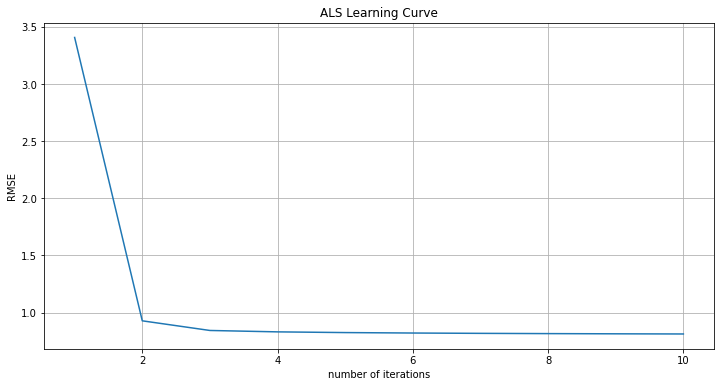

In [29]:
# create an array of num_iters
iter_array = list(range(1, 11))
# create learning curve plot
plot_learning_curve(iter_array, train, validation, 0.05, 14)

After 3 iterations, alternating gradient descend starts to converge at an error around 0.8

### Model testing

And finally, make a prediction and check the testing error using out-of-sample data

In [32]:
        # make prediction using test data
test_data = test.map(lambda p: (p[0], p[1]))
predictions = final_model.predictAll(test_data).map(lambda r: ((r[0], r[1]), r[2]))
    
    # get the rating result
ratesAndPreds = test.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)

    # get the RMSE
MSE = ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean()
error = math.sqrt(MSE)
print('The out-of-sample RMSE of rating predictions is', error)

The out-of-sample RMSE of rating predictions is 0.813280396818649


### Persisting the model

Optionally, we might want to persist the base model for later use in our on-line recommendations. Although a new model is generated everytime we have new user ratings, it might be worth it to store the current one, in order to save time when starting up the server, etc. We might also save time if we persist some of the RDDs we have generated, specially those that took longer to process. For example, the following lines save and load a ALS model.

In [17]:
import os
from pyspark.mllib.recommendation import MatrixFactorizationModel

model_path = os.path.join('../data/02_models', 'movie_lens_als')

# Save and load model
final_model.save(sc, model_path)
same_model = MatrixFactorizationModel.load(sc, model_path)

### Make movie recommendation to myself

We need to define a function that takes new user's movie rating and output top 10 recommendations

To productize a model, we need to build a work flow around the model. Typical ML work flow roughly starts with data preparation via pre-defined set of ETL jobs, offline/online model training, then ingesting trained models to web services for production. In our case, we are going to build a very minimum version of movie recommender that just does the job. Our work flow is following:

- A new user inputs his/her favorite movies, then system create new user-movie interaction samples for the model

- System retrains ALS model on data with the new inputs

- System creates movie data for inference (in my case, I sample all movies from the data)

- System make rating predictions on all movies for that user

- System outputs top N movie recommendations for that user based on the ranking of movie rating predictions

Here is the source code for our MVP recommender system:

In [27]:
def get_movieId(df_movies, fav_movie_list):
    """
    return all movieId(s) of user's favorite movies
    
    Parameters
    ----------
    df_movies: spark Dataframe, movies data
    
    fav_movie_list: list, user's list of favorite movies
    
    Return
    ------
    movieId_list: list of movieId(s)
    """
    movieId_list = []
    for movie in fav_movie_list:
        movieIds = df_movies \
            .filter(raw_movies.title.like('%{}%'.format(movie))) \
            .select('movieId') \
            .rdd \
            .map(lambda r: r[0]) \
            .collect()
        movieId_list.extend(movieIds)
    return list(set(movieId_list))


def add_new_user_to_data(train_data, movieId_list, spark_context):
    """
    add new rows with new user, user's movie and ratings to
    existing train data

    Parameters
    ----------
    train_data: spark RDD, ratings data
    
    movieId_list: list, list of movieId(s)

    spark_context: Spark Context object
    
    Return
    ------
    new train data with the new user's rows
    """
    # get new user id
    new_id = train_data.map(lambda r: r[0]).max() + 1
    # get max rating
    max_rating = train_data.map(lambda r: r[2]).max()
    # create new user rdd
    user_rows = [(new_id, movieId, max_rating) for movieId in movieId_list]
    new_rdd = spark_context.parallelize(user_rows)
    # return new train data
    return train_data.union(new_rdd)


def get_inference_data(train_data, df_movies, movieId_list):
    """
    return a rdd with the userid and all movies (except ones in movieId_list)

    Parameters
    ----------
    train_data: spark RDD, ratings data

    df_movies: spark Dataframe, movies data
    
    movieId_list: list, list of movieId(s)

    Return
    ------
    inference data: Spark RDD
    """
    # get new user id
    new_id = train_data.map(lambda r: r[0]).max() + 1
    # return inference rdd
    return df_movies.rdd \
        .map(lambda r: r[0]) \
        .distinct() \
        .filter(lambda x: x not in movieId_list) \
        .map(lambda x: (new_id, x))


def make_recommendation(best_model_params, ratings_data, df_movies, 
                        fav_movie_list, n_recommendations, spark_context):
    """
    return top n movie recommendation based on user's input list of favorite movies


    Parameters
    ----------
    best_model_params: dict, {'iterations': iter, 'rank': rank, 'lambda_': reg}

    ratings_data: spark RDD, ratings data

    df_movies: spark Dataframe, movies data

    fav_movie_list: list, user's list of favorite movies

    n_recommendations: int, top n recommendations

    spark_context: Spark Context object

    Return
    ------
    list of top n movie recommendations
    """
    # modify train data by adding new user's rows
    movieId_list = get_movieId(df_movies, fav_movie_list)
    train_data = add_new_user_to_data(ratings_data, movieId_list, spark_context)
    
    # train best ALS
    model = ALS.train(
        ratings=train_data,
        iterations=best_model_params.get('iterations', None),
        rank=best_model_params.get('rank', None),
        lambda_=best_model_params.get('lambda_', None),
        seed=99)
    
    # get inference rdd
    inference_rdd = get_inference_data(ratings_data, df_movies, movieId_list)
    
    # inference
    predictions = model.predictAll(inference_rdd).map(lambda r: (r[1], r[2]))
    
    # get top n movieId
    topn_rows = predictions.sortBy(lambda r: r[1], ascending=False).take(n_recommendations)
    topn_ids = [r[0] for r in topn_rows]
    
    # return movie titles
    return df_movies.filter(raw_movies.movieId.isin(topn_ids)) \
                    .select('title') \
                    .rdd \
                    .map(lambda r: r[0]) \
                    .collect()

### Let’s Make Some Recommendations

Once we implemented the ALS recommender system in a python script as a small Pyspark program, we can submit our spark application to a cluster with Client Deploy Mode or Cluster Deploy Mode and enjoy the power of distributed computing.

Finally, we are done with the technical details and implementations. Now let’s ask our recommender for some movie recommendations. I will pretend a new user and input my favorite movie “Iron Man” again into this new recommender system. Let’s see what movies it recommends to me. 

In [28]:
# my favorite movies
my_favorite_movies = ['Iron Man']

# get recommends
recommends = make_recommendation(
    best_model_params={'iterations': 10, 'rank': 14, 'lambda_': 0.05}, 
    ratings_data=rating_data, 
    df_movies=raw_movies, 
    fav_movie_list=my_favorite_movies, 
    n_recommendations=10, 
    spark_context=sc)

print('Recommendations for {}:'.format(my_favorite_movies[0]))
for i, title in enumerate(recommends):
    print('{0}: {1}'.format(i+1, title))

Recommendations for Iron Man:
1: Scarlet Dove, The (Tulipunainen kyyhkynen) (1961)
2: Pearl Jam: Immagine in Cornice - Live in Italy 2006 (2007)
3: Presumed Guilty (Presunto culpable) (2008)
4: The Veil of Twilight (2014)
5: Melhores do Mundo - Hermanoteu na Terra de Godah (2009)
6: Hunterrr (2015)
7: The Flying Dagger (1969)
8: Liar Game: The Final Stage (2010)
9: Heroes Above All (2017)
10: Extinct Pink (1969)


This list of movie recommendations looks good for an action movie like Iron Man. The recommender not only recommends movies outside of years between 2007 and 2009 periods, but also recommends movies that were less known. So this can offer users some elements of suprise so that users won't get bored by getting the same popular movies all the time.

In [39]:
sc.stop()

***

***